In [23]:
import itertools
import json
import os
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
import seaborn as sns

import common

data_paths = ["../output/navigation3"]
data_files = [os.path.join(data_path, f) for data_path in data_paths for f in os.listdir(data_path) if not os.path.isdir(os.path.join(data_path, f))]

plt.style.use('default')

parameters = {
    'axes.labelsize': 20,
    'axes.titlesize': 22,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'legend.title_fontsize': 18,
}
plt.rcParams.update(parameters)

In [24]:
data_files = common.get_data_files_from_paths(data_paths)
print(f"Found {len(data_files)} data files")

Found 144 data files


In [25]:
def read_json(file_name):
    with open(file_name) as json_data:
        return json.load(json_data)        

In [26]:
def read_file_data(file_name):
    heuristics_spl = file_name.split('/')[0].split('_')
    return {
        **read_json(file_name),
        'output_file_name': file_name,
    }

In [27]:
info_runs = [read_file_data(file_name) for file_name in data_files]
len(info_runs)

144

In [28]:
problem_runs = common.filter_runs_by_props(info_runs, ("args.problem_index", 0))

params_values = {}
for run in problem_runs:
    for param, val in run['args'].items():
        if param not in params_values:
            params_values[param] = set()
        params_values[param].add(val)

params_values_strings = {param: json.dumps(sorted(list(values))) for param, values in params_values.items()}
df = pd.DataFrame(params_values_strings.values(), index=params_values_strings.keys())
df

,0
env,"[""PDDLEnvNavigation3-v0""]"
problem_index,[0]
horizon,[50]
n_rollouts,"[100, 500, 1000]"
n_rounds,[15]
n_sim_steps,[25]
exploration_constant,[1.414]
norm_exploration_constant,"[false, true]"
h_init_count,"[1, 20]"
k_g,"[1e-10, 1e-05, 1.0]"


In [29]:
import re
runs_by_envs = {}
for run in info_runs:
    if 'env' not in run:
        spls = run['output_file_name'].split('/')
        domain_name = spls[2]
        mtc = re.match(r"([a-z])+(\d+)", domain_name)
        n = mtc.groups()[1]
#         print("deu errado!", run['output_file_name'], domain_name)
        run['env'] = f'PDDLEnvNavigation{n}-v0'
#         print(run['env'])
    env = run['env']
    if env not in runs_by_envs:
        runs_by_envs[env] = []
    runs_by_envs[env].append(run)


In [30]:
set([run['args']['lamb'] for run in runs_by_envs['PDDLEnvNavigation3-v0']])

{-0.1}

# Optimal values

In [31]:
# optimal values

optimal_vals = {
    # key: problem index
    1: [
        (-0.1, 1e-10, ("move(left:direction)", 0.30388546107671893, 0.9129223770637188)),
        (-0.1, 1e-5, ("move(left:direction)",0.3038945902091973,0.9129223770637188)),
        (-0.1, 1, ("move(left:direction)",1.2168078380491454,0.9129223770637188)),
    ],
}

optimal_actions_by_lamb_tireworld_1_1e10 = common.get_res_by_lamb(0, 1e-10, 1, optimal_vals)
optimal_qs_by_lamb_tireworld_1_1e10 = common.get_res_by_lamb(1, 1e-10, 1, optimal_vals)
optimal_probs_by_lamb_tireworld_1_1e10 = common.get_res_by_lamb(2, 1e-10, 1, optimal_vals)

optimal_actions_by_kg_tireworld_1_01 = common.get_res_by_kg(0, -0.1, 1, optimal_vals)
optimal_qs_by_kg_tireworld_1_01 = common.get_res_by_kg(1, -0.1, 1, optimal_vals)
optimal_probs_by_kg_tireworld_1_01 = common.get_res_by_kg(2, -0.1, 1, optimal_vals)

print(
    optimal_actions_by_lamb_tireworld_1_1e10, '\n',
    optimal_qs_by_lamb_tireworld_1_1e10, '\n',
    optimal_probs_by_lamb_tireworld_1_1e10, '\n',
    optimal_actions_by_kg_tireworld_1_01, '\n',
    optimal_qs_by_kg_tireworld_1_01, '\n',
    optimal_probs_by_kg_tireworld_1_01
)

{-0.1: 'move(left:direction)'} 
 {-0.1: 0.30388546107671893} 
 {-0.1: 0.9129223770637188} 
 {1e-05: 'move(left:direction)', 1: 'move(left:direction)', 1e-10: 'move(left:direction)'} 
 {1e-05: 0.3038945902091973, 1: 1.2168078380491454, 1e-10: 0.30388546107671893} 
 {1e-05: 0.9129223770637188, 1: 0.9129223770637188, 1e-10: 0.9129223770637188}


In [32]:
kg_opt_probs = np.array([optimal_probs_by_lamb_tireworld_1_1e10[k_g] for k_g in sorted(optimal_probs_by_lamb_tireworld_1_1e10)])
lamb_opt_probs = np.array([optimal_probs_by_kg_tireworld_1_01[key] for key in sorted(optimal_probs_by_kg_tireworld_1_01)], dtype=float)
lamb_opt_qs = np.array([optimal_qs_by_kg_tireworld_1_01[key] for key in sorted(optimal_qs_by_kg_tireworld_1_01)], dtype=float)
kg_opt_qs = np.array([optimal_qs_by_lamb_tireworld_1_1e10[key] for key in sorted(optimal_qs_by_lamb_tireworld_1_1e10)], dtype=float)

# Evaluate heuristics

In [33]:
# Parâmetros:
#       base_params -> parâmetros fixados
#       parâmetros das linhas -> o que vai ser variado em cada linha plotada no gráfico
#       variável fixa - cada plot representa um valor fixado dessa variável - ex: lambda
#       parâmetro x que varia -> o que vai aparecer no eixo x dos plots - ex: k_g
#       parâmetros de cada conjunto de plots - o eixo y do que vai ser mostrado nos plots.
#         Cada um é um conjunto de plots diferentes

In [34]:
# Evaluate heuristics

base_params = [("args.problem_index", 0), ("args.n_rollouts", 1000), ("args.h_init_count", 20), ("args.norm_exploration_constant", True), ("args.horizon", 50)]

h1_runs = common.filter_runs_by_props(info_runs, ("args.h_p", "h1"), ("args.h_u", "h1"), *base_params)
h1p_runs = common.filter_runs_by_props(info_runs, ("args.h_p", "h1"), ("args.h_u", "shortest_path"), *base_params)
h1u_runs = common.filter_runs_by_props(info_runs, ("args.h_p", "handcrafted"), ("args.h_u", "h1"), *base_params)
h_runs = common.filter_runs_by_props(info_runs, ("args.h_p", "handcrafted"), ("args.h_u", "shortest_path"), *base_params)

# check for intersection - shouldn't have any
# ----------------------------------------------------------------
common.check_for_intersections([
    h1_runs,
    h1p_runs,
    h1u_runs,
    h_runs
])
# ----------------------------------------------------------------

print(len(info_runs), len(h1_runs), len(h1p_runs), len(h1u_runs), len(h_runs))

144 3 3 3 3


actions: ['move(up:direction)']
  sub[2]: [[15, 15, 15]] 1 [0, 0, 0]
  sub[2]: [[15, 15, 15]] 1 [0, 0, 0]
  sub[2]: [[15, 15, 15]] 1 [0, 0, 0]
  sub[2]: [[15, 15, 15]] 1 [0, 0, 0]
lamb
[(array([1.e-10, 1.e-05, 1.e+00]), ['move(up:direction)'], [[15, 15, 15]]),
 (array([1.e-10, 1.e-05, 1.e+00]), ['move(up:direction)'], [[15, 15, 15]]),
 (array([1.e-10, 1.e-05, 1.e+00]), ['move(up:direction)'], [[15, 15, 15]]),
 (array([1.e-10, 1.e-05, 1.e+00]), ['move(up:direction)'], [[15, 15, 15]])]
actions: ['move(up:direction)']
  sub[2]: [[15]] 1 [0]
  sub[2]: [[15]] 1 [0]
  sub[2]: [[15]] 1 [0]
  sub[2]: [[15]] 1 [0]
kg
[(array([-0.1]), ['move(up:direction)'], [[15]]),
 (array([-0.1]), ['move(up:direction)'], [[15]]),
 (array([-0.1]), ['move(up:direction)'], [[15]]),
 (array([-0.1]), ['move(up:direction)'], [[15]])]
[[(array([1.e-10, 1.e-05, 1.e+00]),
   [[15, 15, 15], [15, 15, 15], [15, 15, 15], [15, 15, 15]])],
 [(array([-0.1]), [[15], [15], [15], [15]])]]


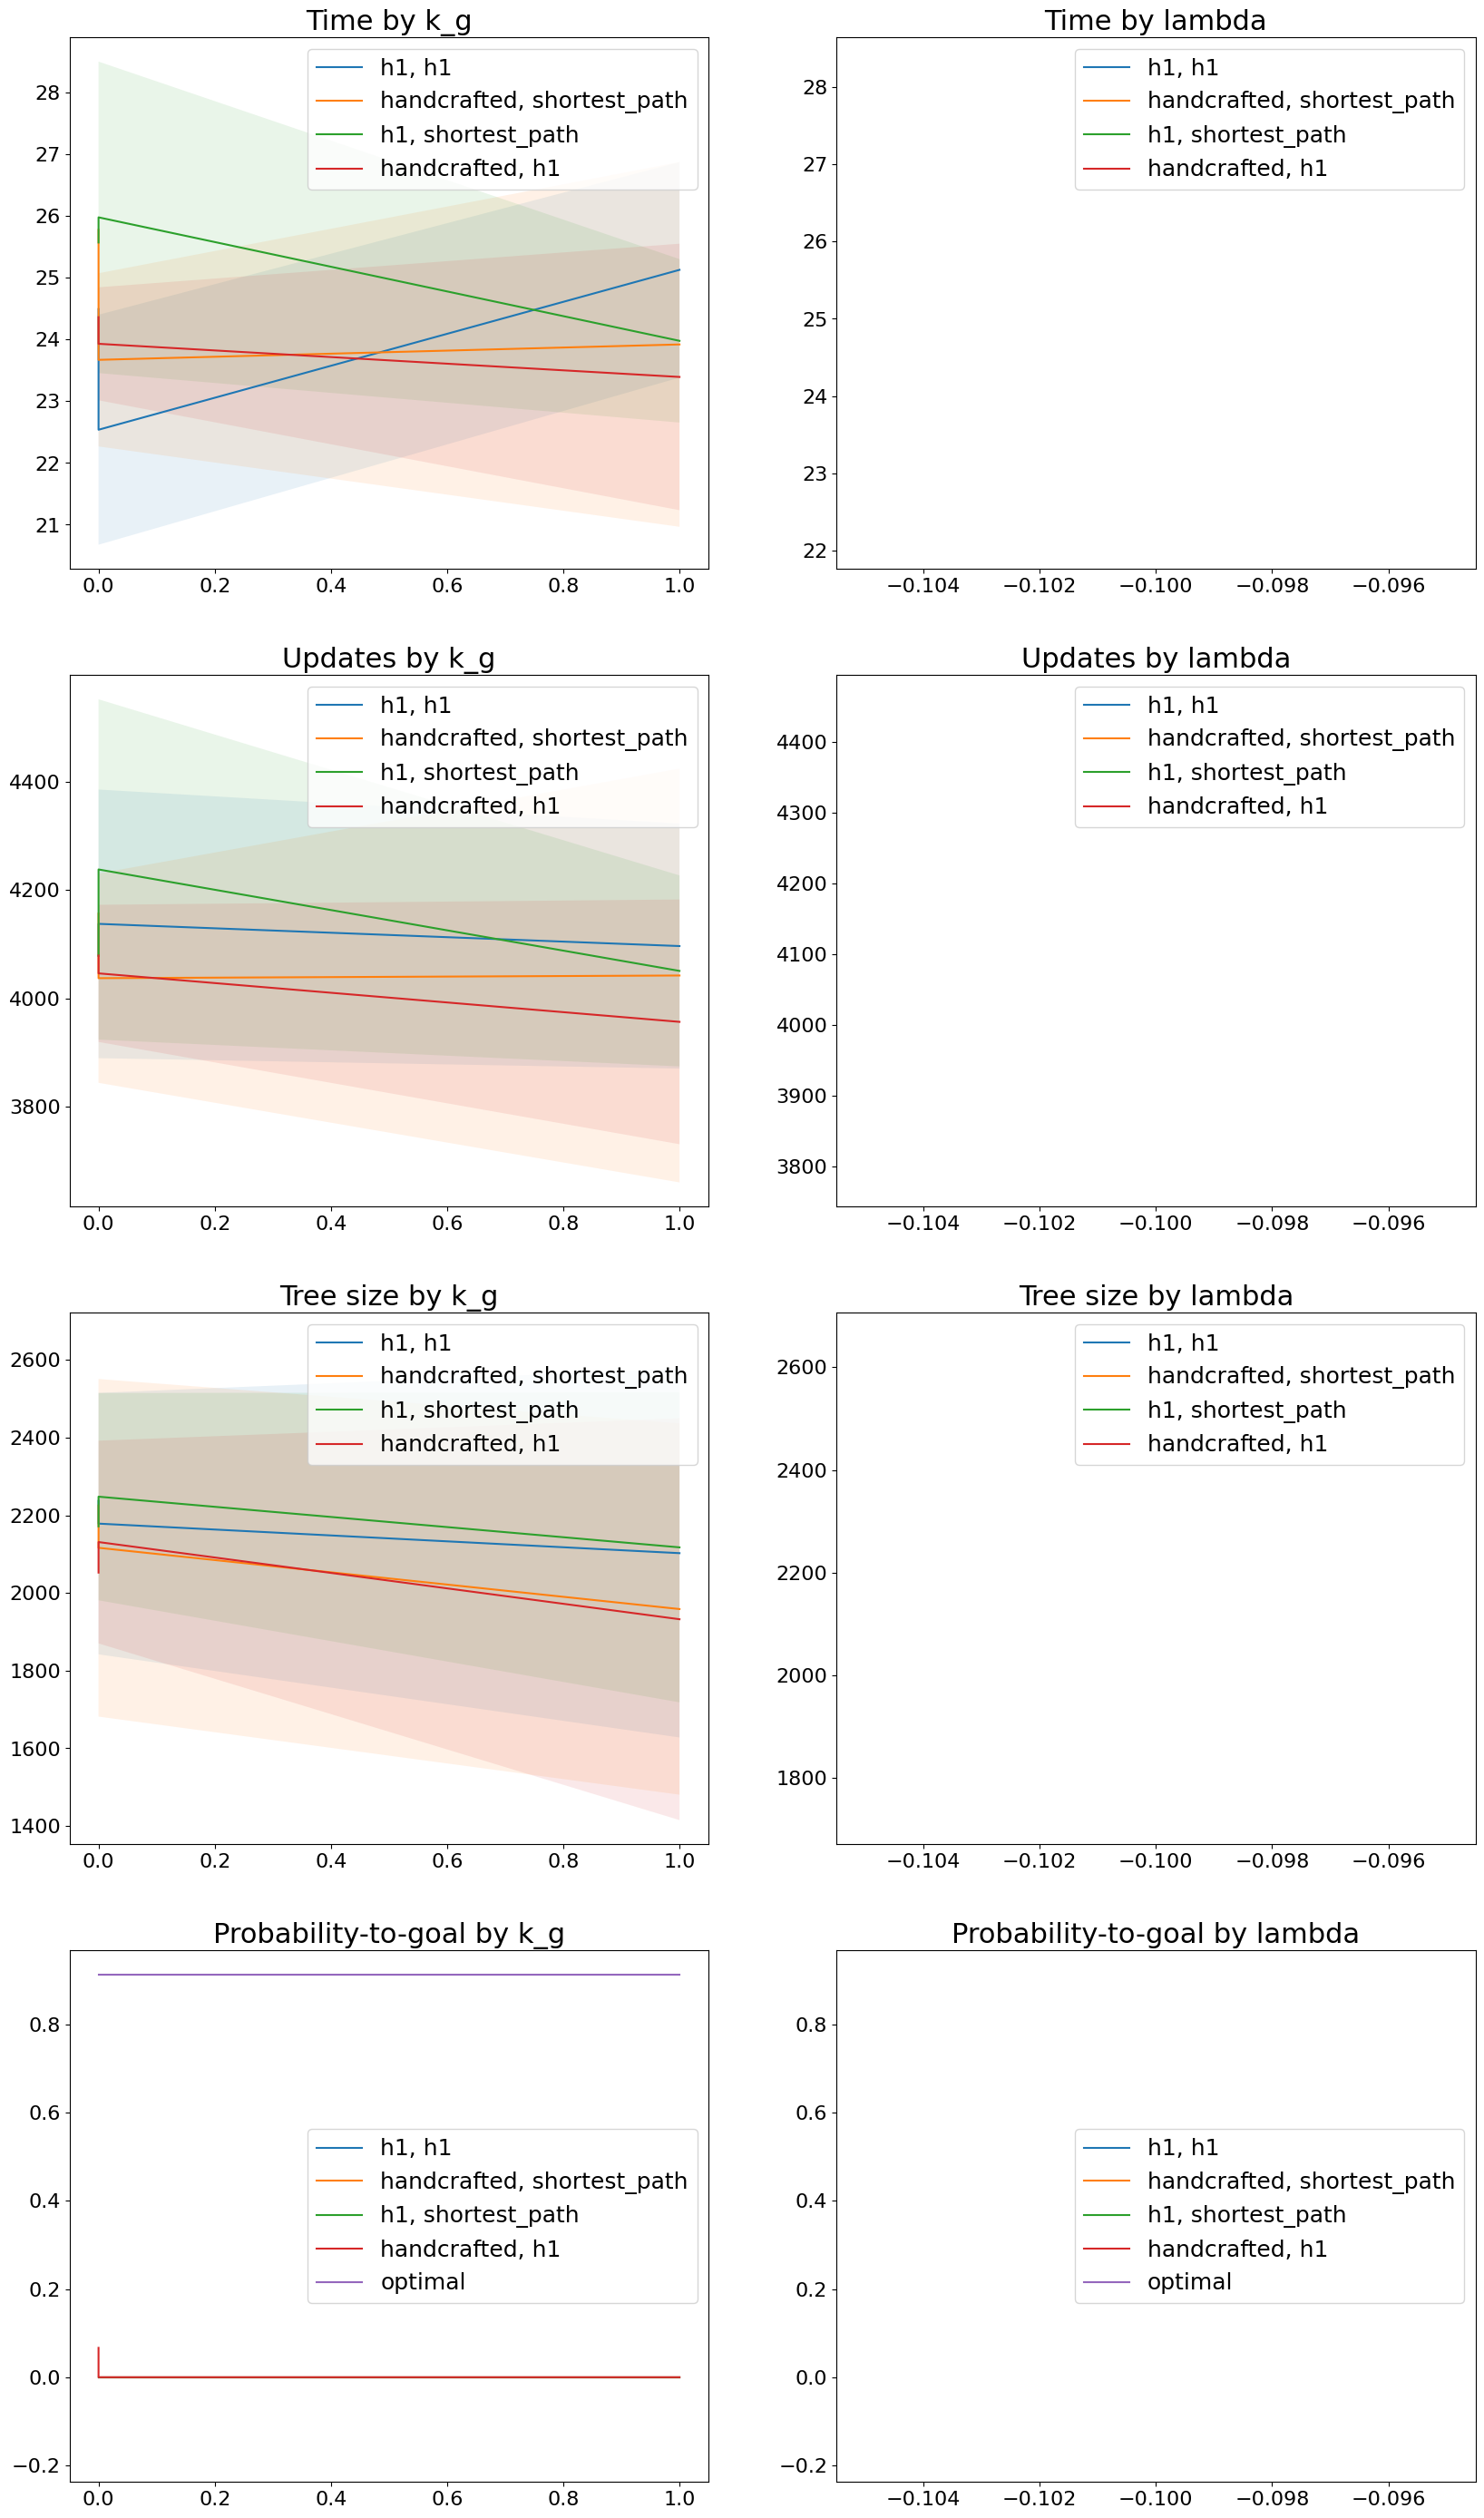

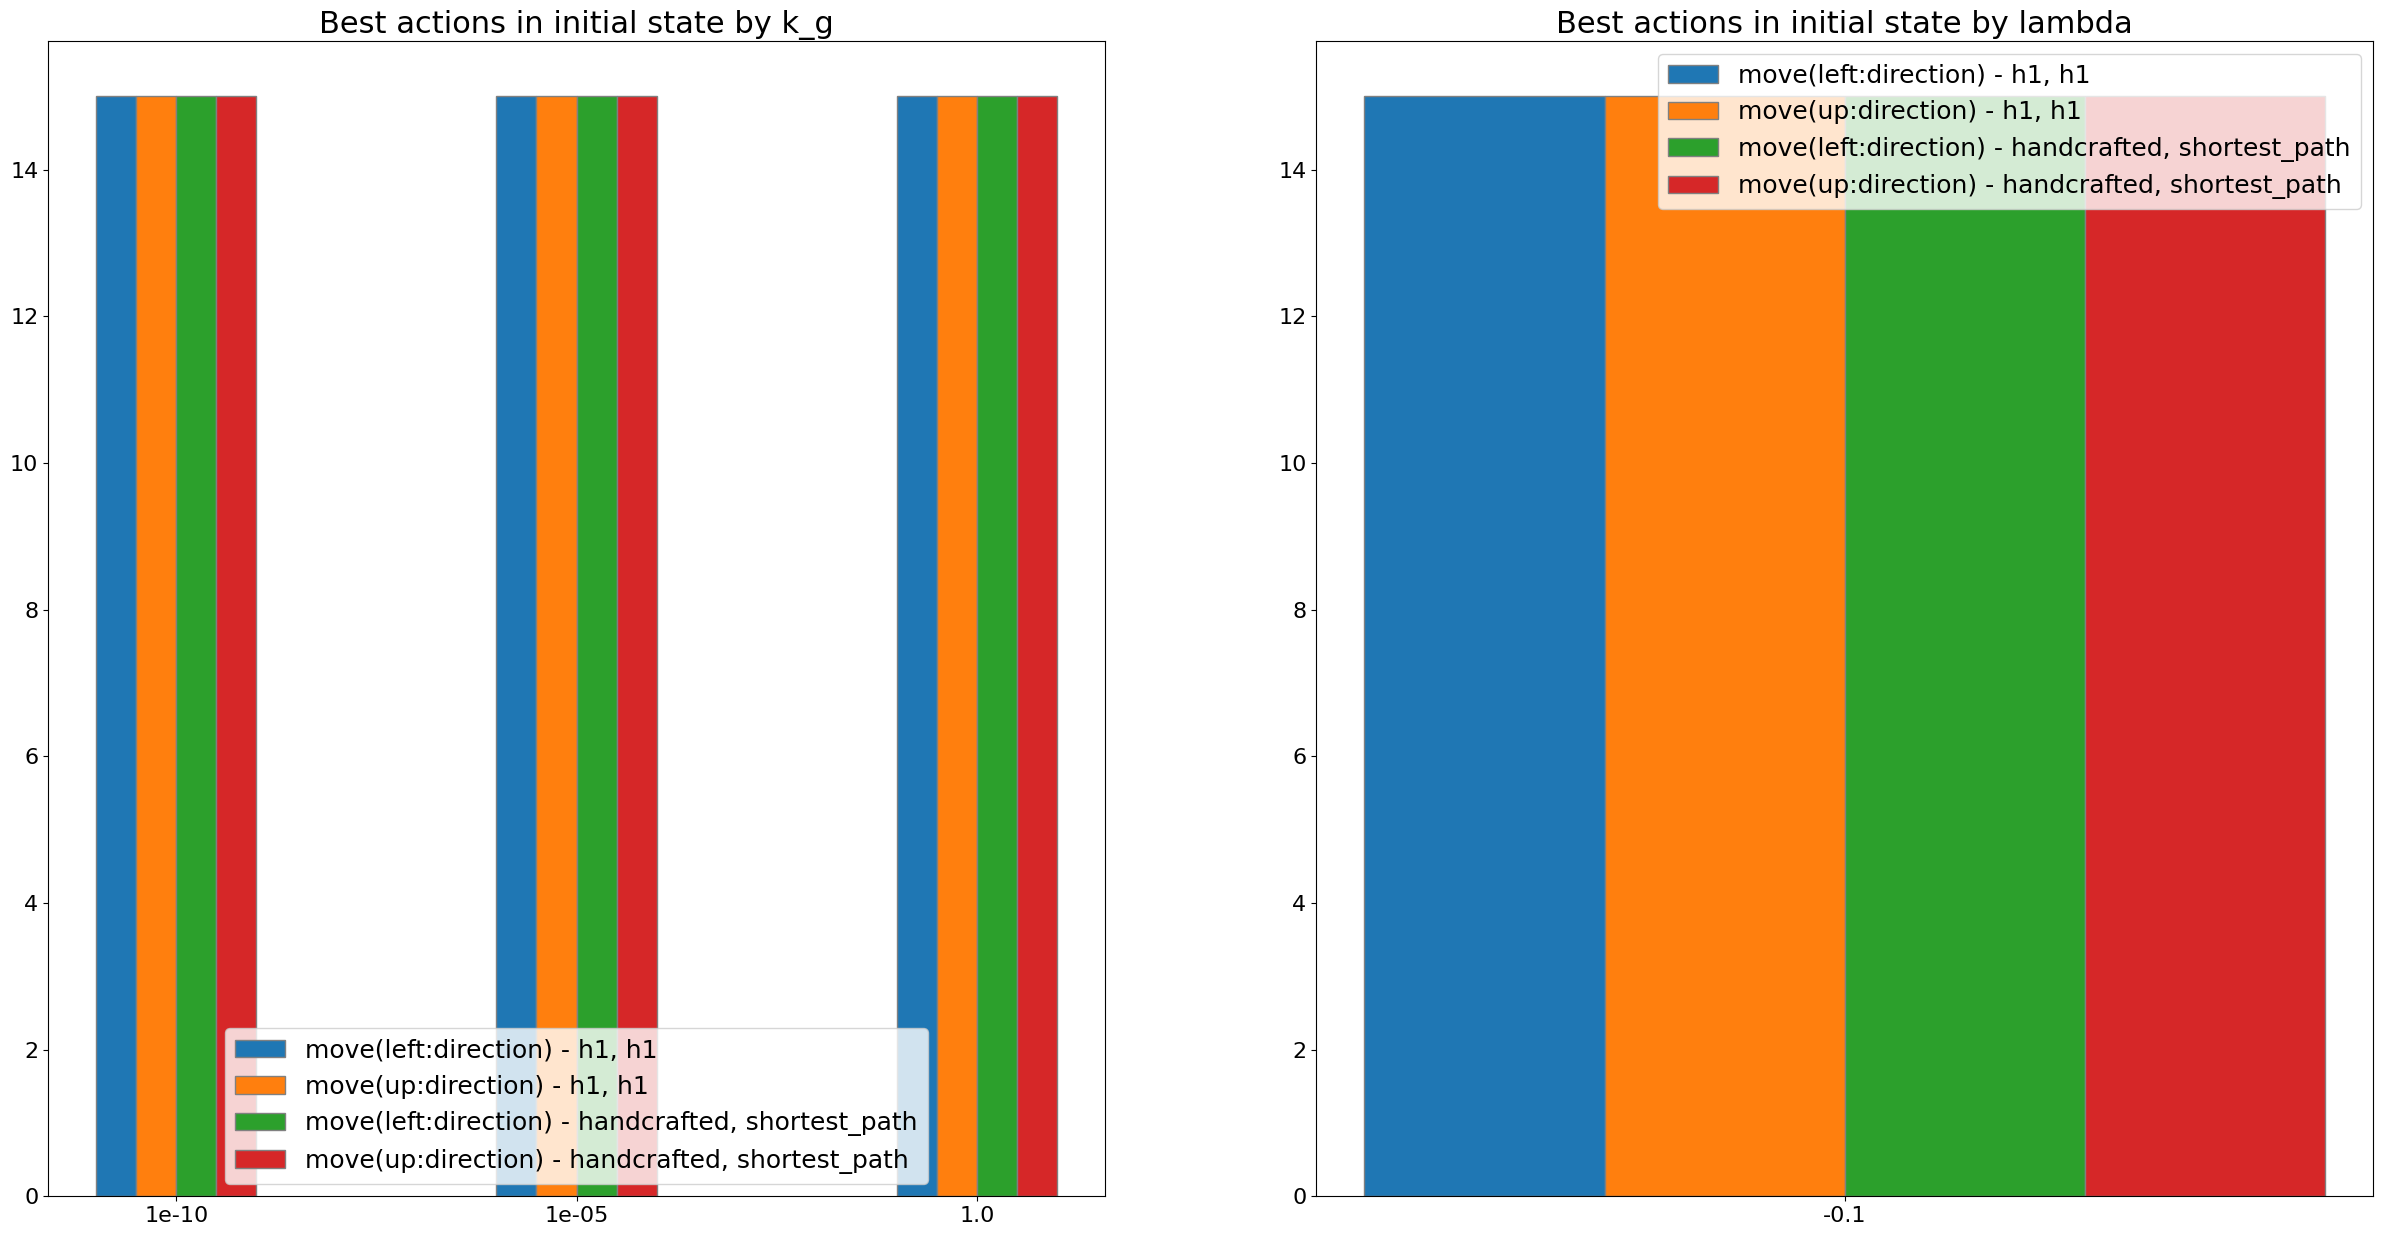

In [36]:
# fix k_g and leave lambda as variable
y_vars = [
    ("cpu_times", "line"),
    ("n_updates", "line"),
    ("tree_sizes", "line"),
    ("found_goal", "line"),
    ("values_s0", "line"),
    ("best_actions_s0", "bar")
]

source_runs = [
    h1_runs,
    h_runs,
    h1p_runs,
    h1u_runs,
]


plot_data_lamb = common.get_plot_data_by_fixed_var_from_sources(
    "args.lamb", -0.1,
    "args.k_g", y_vars,
    source_runs
)

(
    sources_lambda_fixed_time,
    sources_lambda_fixed_n_updates,
    sources_lambda_fixed_size,
    sources_lambda_fixed_prob,
    sources_lambda_fixed_q,
    _sources_lamb_best_actions
) = common.get_plot_source_from_plot_data(plot_data_lamb)
sources_lamb_best_actions = common.parse_best_actions_plot_source(_sources_lamb_best_actions)
print("lamb")
pprint(_sources_lamb_best_actions)

plot_data_kg = common.get_plot_data_by_fixed_var_from_sources(
    "args.k_g", 1e-10,
    "args.lamb", y_vars,
    source_runs
)

(
    sources_kg_fixed_time,
    sources_kg_fixed_n_updates,
    sources_kg_fixed_size,
    sources_kg_fixed_prob,
    sources_kg_fixed_q,
    _sources_kg_best_actions
) = common.get_plot_source_from_plot_data(plot_data_kg)
sources_kg_best_actions = common.parse_best_actions_plot_source(_sources_kg_best_actions)
print("kg")
pprint(_sources_kg_best_actions)
actions = _sources_kg_best_actions[0][1]

labels = ["h1, h1", "handcrafted, shortest_path", "h1, shortest_path", "handcrafted, h1", "optimal"]

titles = [
    ["Time by k_g", "Time by lambda"],
    ["Updates by k_g", "Updates by lambda"],
    ["Tree size by k_g", "Tree size by lambda"],
    ["Probability-to-goal by k_g", "Probability-to-goal by lambda"],
    ["q-value by k_g", "q-value by lambda"]
]


common.plot_multiple_from_plot_data_source_sets(
    [
        [sources_lambda_fixed_time, sources_kg_fixed_time],
        [sources_lambda_fixed_n_updates, sources_kg_fixed_n_updates],
        [sources_lambda_fixed_size, sources_kg_fixed_size],
        [
            sources_lambda_fixed_prob + [(sources_lambda_fixed_prob[-1][0], lamb_opt_probs)],
            sources_kg_fixed_prob + [(sources_kg_fixed_prob[-1][0], kg_opt_probs)]
        ],
        [
            sources_lambda_fixed_q + [(sources_lambda_fixed_q[-1][0], lamb_opt_qs)],
            sources_kg_fixed_q + [(sources_kg_fixed_q[-1][0], kg_opt_qs)]
        ]
    ],
    titles, labels, (5, 2), (20, 35), plot_type="line"
)

# Plot best actions at s0

labels = [
    'move(left:direction) - h1, h1',
    'move(up:direction) - h1, h1',
    'move(left:direction) - handcrafted, shortest_path',
    'move(up:direction) - handcrafted, shortest_path',
    'move(left:direction) - h1, shortest_path',
    'move(up:direction) - h1, shortest_path',
    'move(left:direction) - handcrafted, h1',
    'move(up:direction) - handcrafted, h1',
]
titles = [["Best actions in initial state by k_g", "Best actions in initial state by lambda"]]

pprint([sources_lamb_best_actions, sources_kg_best_actions])

common.plot_multiple_from_plot_data_source_sets(
    [[sources_lamb_best_actions, sources_kg_best_actions]],
    titles, [labels, labels], (1, 2), (30, 15), bar_width=0.1, plot_type="bar"
)


In [16]:
df

,0
env,"[""PDDLEnvNavigation3-v0""]"
problem_index,[0]
horizon,[50]
n_rollouts,"[100, 500, 1000]"
n_rounds,[15]
n_sim_steps,[25]
exploration_constant,[1.414]
norm_exploration_constant,"[false, true]"
h_init_count,"[1, 20]"
k_g,"[1e-10, 1e-05, 1.0]"


# Evaluate normalizing
PS: currently we don't have data for runs without normalization

In [17]:
# # Evaluate normalizing

base_params = [
    ("args.problem_index", 0), ("args.n_rollouts", 1000),
    ("args.h_init_count", 20), ("args.horizon", 50),
    ("args.h_u", "shortest_path"), ("args.h_p", "handcrafted")
]

norm_runs = common.filter_runs_by_props(info_runs, ("args.norm_exploration_constant", True), *base_params)
no_norm_runs = common.filter_runs_by_props(info_runs, ("args.norm_exploration_constant", False), *base_params)

# check for intersection - shouldn't have any
# ----------------------------------------------------------------
common.check_for_intersections([
    norm_runs,
    no_norm_runs
])
# ----------------------------------------------------------------

print(len(norm_runs), len(no_norm_runs))

3 3


actions: ['move(up:direction)']
  sub[2]: [[15, 15, 15]] 1 [0, 0, 0]
  sub[2]: [[15, 15, 15]] 1 [0, 0, 0]
actions: ['move(up:direction)']
  sub[2]: [[15]] 1 [0]
  sub[2]: [[15]] 1 [0]


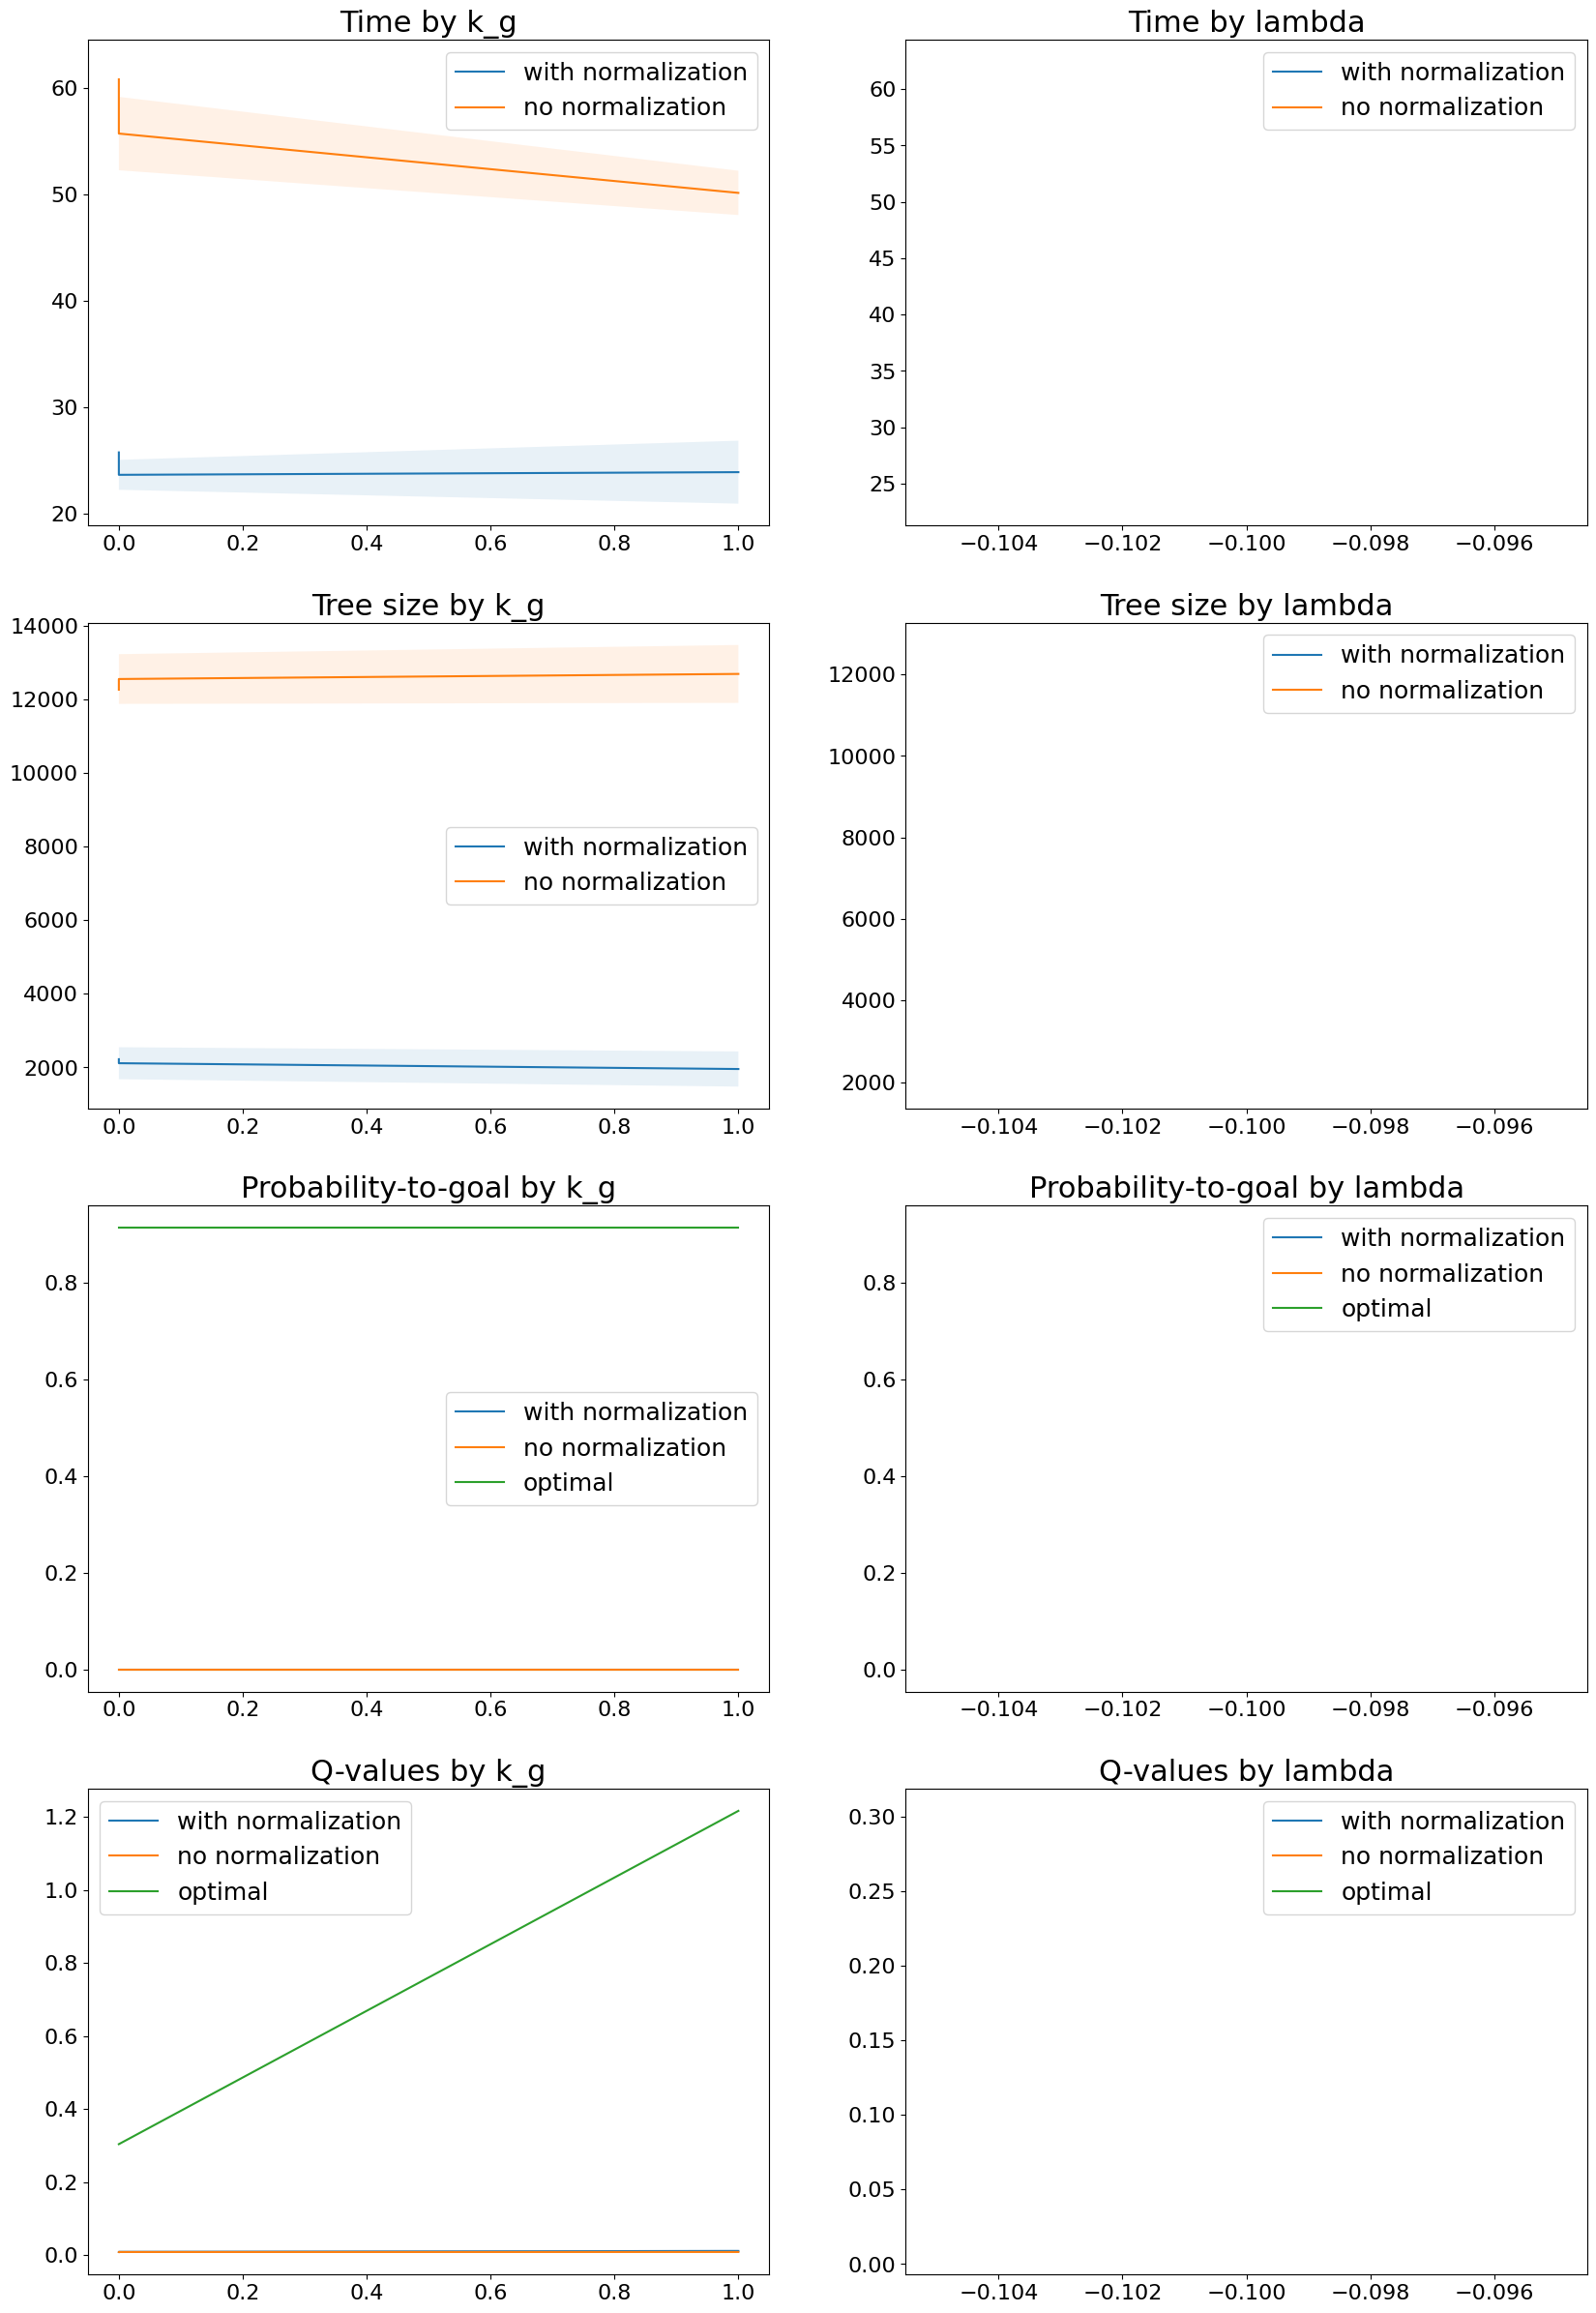

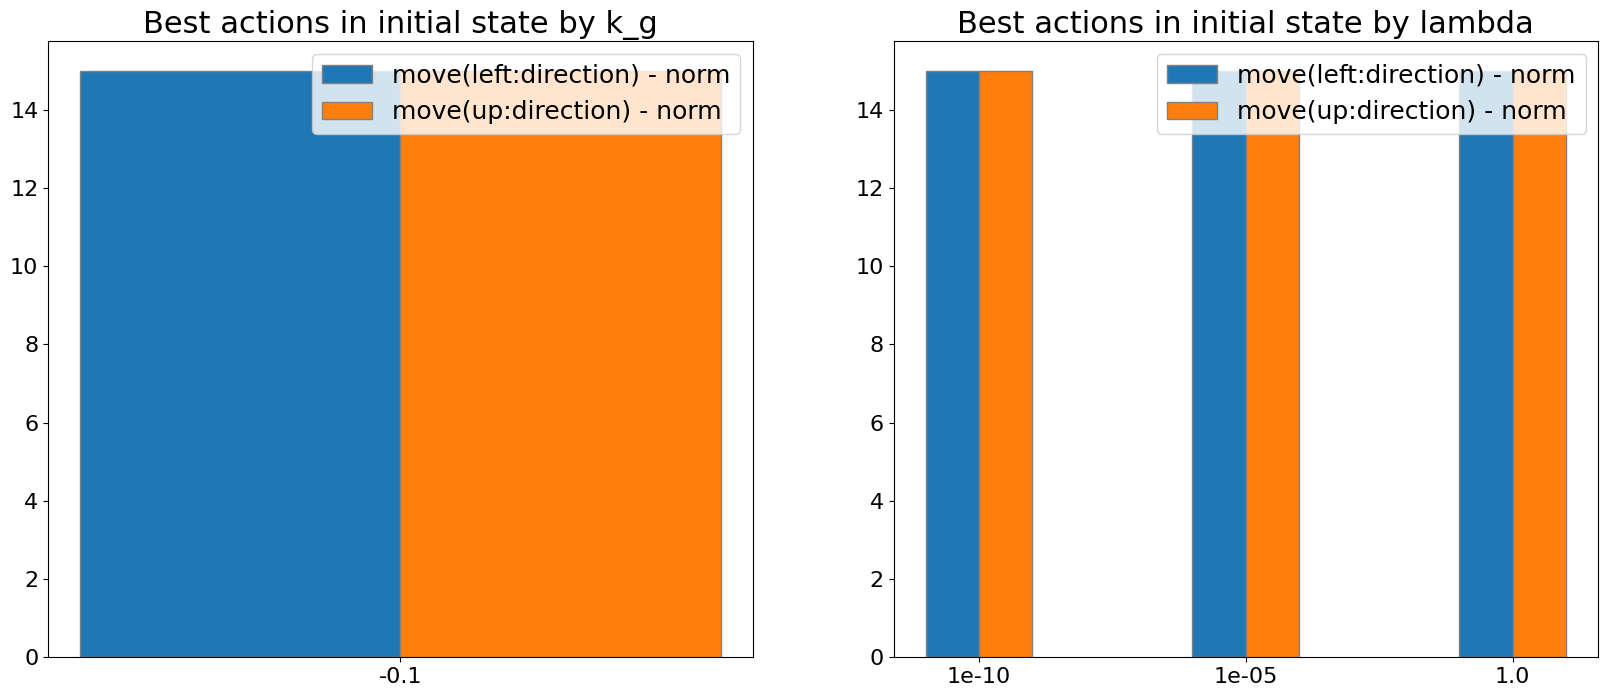

In [18]:
# fix lambda and leave kg as variable

y_vars = [
    ("cpu_times", "line"),
    ("tree_sizes", "line"),
    ("found_goal", "line"),
    ("values_s0", "line"),
    ("best_actions_s0", "bar")
]
source_runs = [
    norm_runs,
    no_norm_runs
]

plot_datas_by_kg = common.get_plot_data_by_fixed_var_from_sources(
    "args.lamb", -0.1,
    "args.k_g", y_vars,
    source_runs
)

(sources_lambda_fixed_time,
sources_lambda_fixed_size, 
sources_lambda_fixed_prob, 
sources_lambda_fixed_qs, 
_sources_lamb_best_actions) = common.get_plot_source_from_plot_data(plot_datas_by_kg)
sources_lamb_best_actions = common.parse_best_actions_plot_source(_sources_lamb_best_actions)


# fix k_g and leave lambda as variable
plot_datas_by_lamb = common.get_plot_data_by_fixed_var_from_sources(
    "args.k_g", 1e-10,
    "args.lamb", y_vars,
    source_runs
)

(sources_kg_fixed_time,
sources_kg_fixed_size,
sources_kg_fixed_prob,
sources_kg_fixed_qs,
_sources_kg_best_actions) = common.get_plot_source_from_plot_data(plot_datas_by_lamb)
sources_kg_best_actions = common.parse_best_actions_plot_source(_sources_kg_best_actions)

labels = ["with normalization", "no normalization", "optimal"]
titles = [
    ["Time by k_g", "Time by lambda"],
    ["Tree size by k_g", "Tree size by lambda"],
    ["Probability-to-goal by k_g", "Probability-to-goal by lambda"],
    ["Q-values by k_g", "Q-values by lambda"],
]

common.plot_multiple_from_plot_data_source_sets([
    [sources_lambda_fixed_time, sources_kg_fixed_time],
    [sources_lambda_fixed_size, sources_kg_fixed_size],
    [
        sources_lambda_fixed_prob + [(sources_lambda_fixed_prob[-1][0], lamb_opt_probs)],
        sources_kg_fixed_prob + [(sources_kg_fixed_prob[-1][0], kg_opt_probs)]
    ],
    [
        sources_lambda_fixed_qs + [(sources_lambda_fixed_qs[-1][0], lamb_opt_qs)],
        sources_kg_fixed_qs + [(sources_kg_fixed_qs[-1][0], kg_opt_qs)]
    ]
], titles, labels, (5, 2), (20, 30))


# Plot best actions at s0

labels = [
    'move(left:direction) - norm',
    'move(up:direction) - norm',
    'move(left:direction) - no norm',
    'move(up:direction) - no norm'
]
titles = [["Best actions in initial state by k_g", "Best actions in initial state by lambda"]]


# pprint(sources_kg_best_actions)
common.plot_multiple_from_plot_data_source_sets(
    [[sources_kg_best_actions, sources_lamb_best_actions]],
    titles, [labels, labels], (1, 2), (20, 8), bar_width=0.2, plot_type="bar"
)

# Evaluate number of rollouts

In [19]:
# Evaluate normalizing

base_params = [
    ("args.problem_index", 0), ("args.norm_exploration_constant", True),
    ("args.h_init_count", 20), ("args.horizon", 50),
    ("args.h_u", "shortest_path"), ("args.h_p", "handcrafted")
]

n_rollouts_100_runs   = common.filter_runs_by_props(info_runs, ("args.n_rollouts", 100), *base_params)
n_rollouts_1000_runs = common.filter_runs_by_props(info_runs, ("args.n_rollouts", 1000), *base_params)

# check for intersection - shouldn't have any
# ----------------------------------------------------------------
common.check_for_intersections([
    n_rollouts_100_runs,
    n_rollouts_1000_runs
])
# ----------------------------------------------------------------


print(len(n_rollouts_100_runs), len(n_rollouts_1000_runs))

3 3


In [20]:
pprint(sorted(list(set([(run['args']['k_g'], run['args']['lamb']) for run in n_rollouts_100_runs]))))
pprint(sorted(list(set([(run['args']['k_g'], run['args']['lamb']) for run in n_rollouts_1000_runs]))))

[(1e-10, -0.1), (1e-05, -0.1), (1.0, -0.1)]
[(1e-10, -0.1), (1e-05, -0.1), (1.0, -0.1)]


Aqui ta dando erro porque ta faltando dados pra 100 rollouts com lambda = -0.1

Pra ajeitar isso, rodar o seguinte comando de experimentos:

```
python experiments.py --env "[PDDLEnvNavigation1-v0]" --problem_index "[0]" --lambda "[-0.1]" --k_g "[1, 1e-5, 1e-10]" --horizon "[50]" --n_rollouts "[100]" --n_rounds "[15]" --h_init_count "[20]" --n_sim_steps "[25]" --h_u "[shortest_path, h1]" --h_p "[handcrafted, h1]" --exploration_constant "[1.414]" --norm_exploration_constant "[True]"
```

In [21]:
set([a for run in n_rollouts_1000_runs for a in run['best_actions_s0']])

{'move(up:direction)'}

actions: ['move(up:direction)']
  sub[2]: [[15, 15, 15]] 1 [0, 0, 0]
  sub[2]: [[15, 15, 15]] 1 [0, 0, 0]
actions: ['move(up:direction)']
  sub[2]: [[15]] 1 [0]
  sub[2]: [[15]] 1 [0]
actions: ['move(up:direction)']
  sub[2]: [[15, 15, 15]] 1 [0, 0, 0]
  sub[2]: [[15, 15, 15]] 1 [0, 0, 0]
lamb
[(array([1.e-10, 1.e-05, 1.e+00]), ['move(up:direction)'], [[15, 15, 15]]),
 (array([1.e-10, 1.e-05, 1.e+00]), ['move(up:direction)'], [[15, 15, 15]])]
kg
[(array([-0.1]), ['move(up:direction)'], [[15]]),
 (array([-0.1]), ['move(up:direction)'], [[15]])]


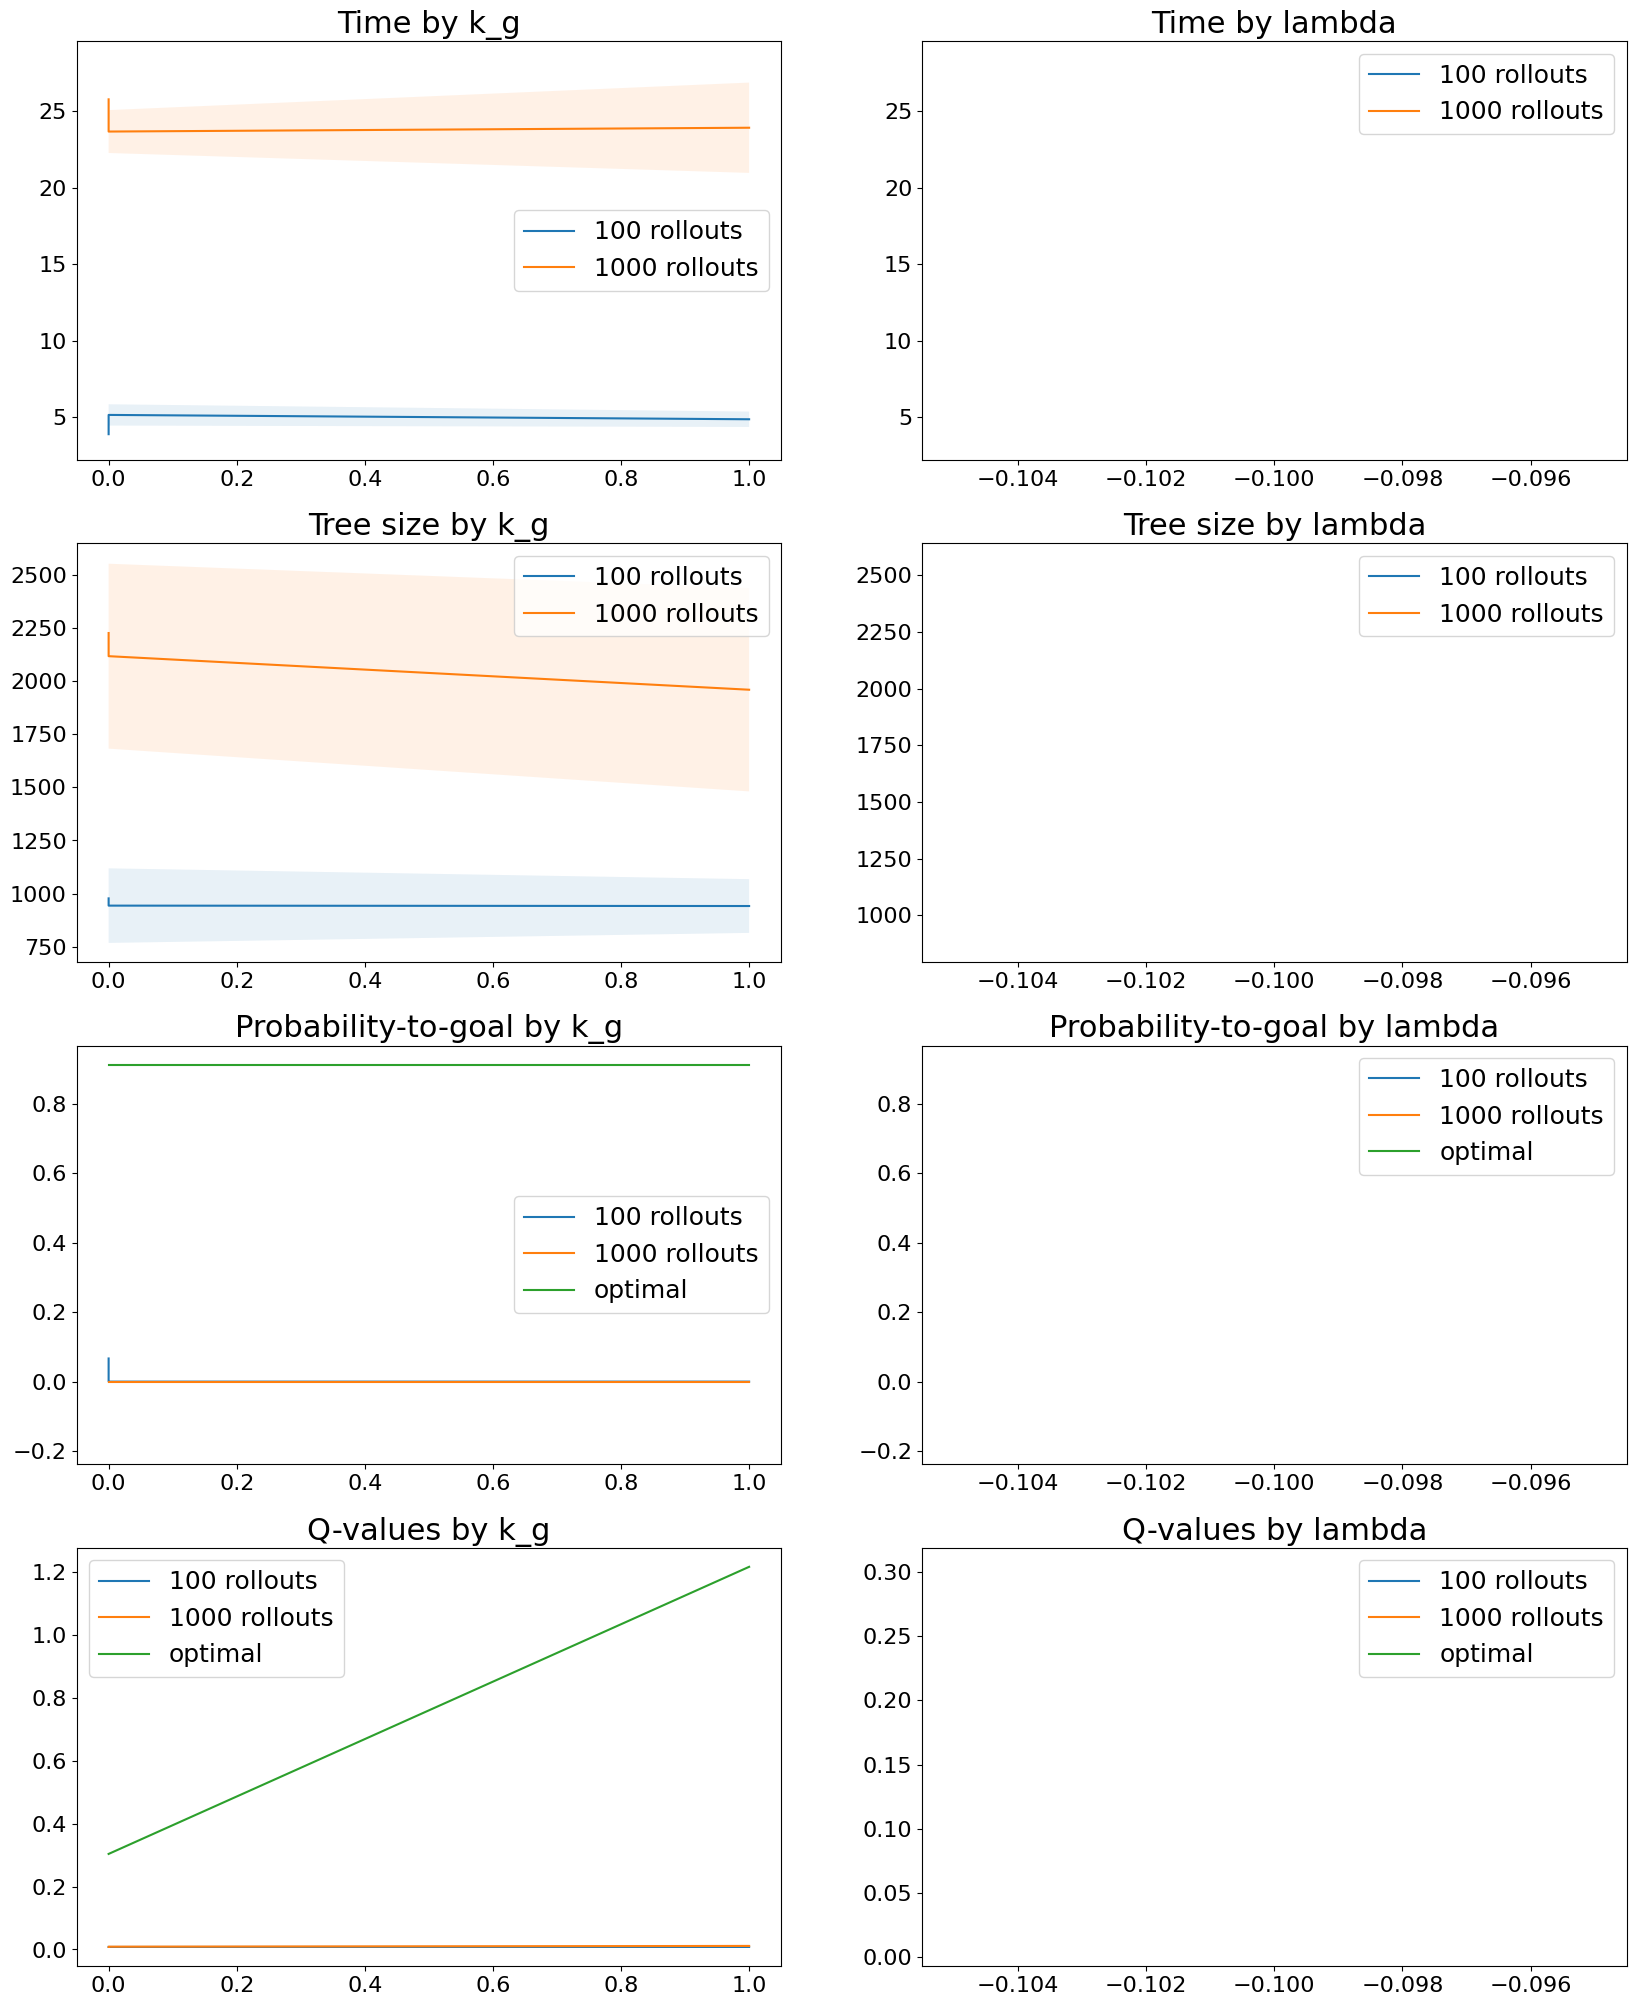

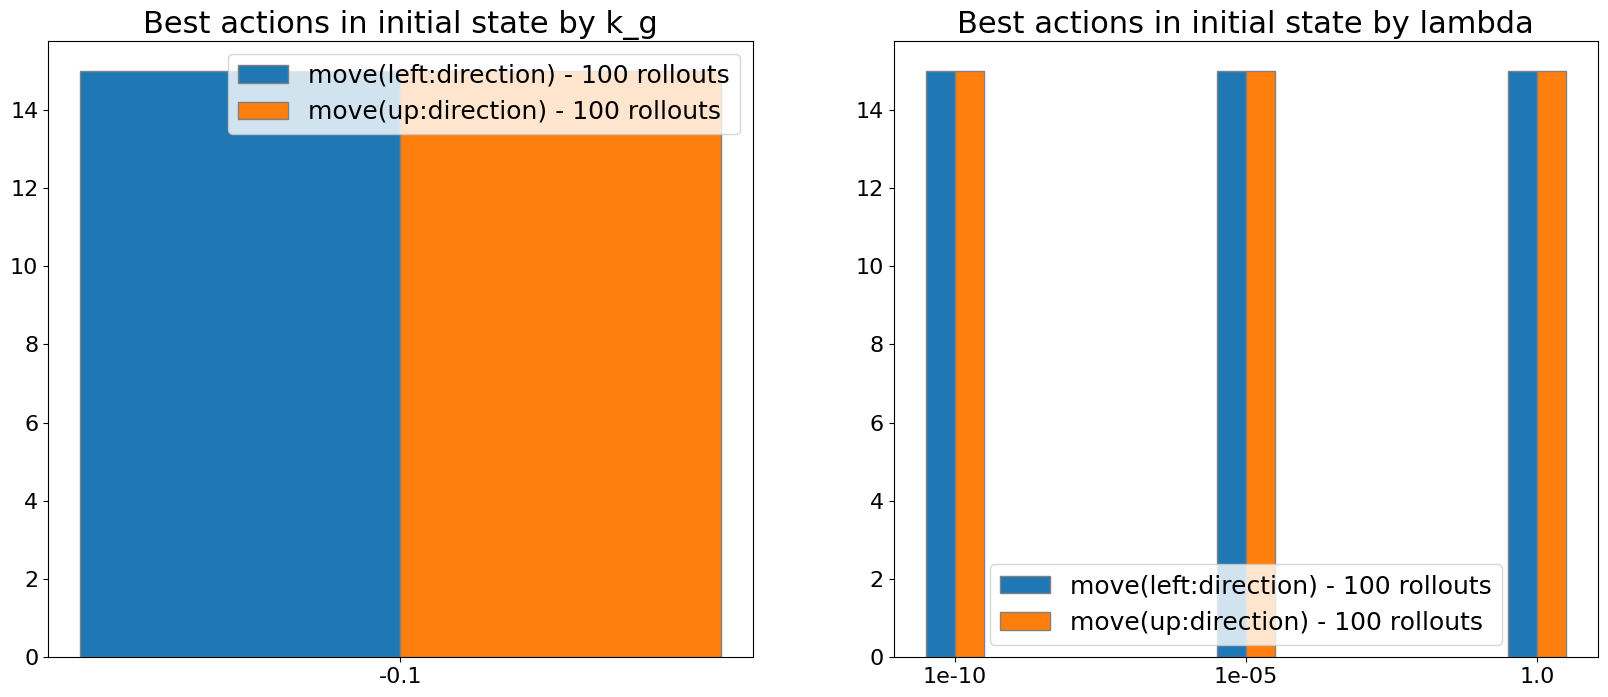

In [22]:
# fix lambda and leave kg as variable

y_vars = [
    ("cpu_times", "line"),
    ("tree_sizes", "line"),
    ("found_goal", "line"),
    ("values_s0", "line"),
    ("best_actions_s0", "bar")
]

source_runs = [
    n_rollouts_100_runs,
    n_rollouts_1000_runs
]

# fix lambda and leave k_g as variable
plot_datas_by_kg = common.get_plot_data_by_fixed_var_from_sources(
    "args.lamb", -0.1,
    "args.k_g", y_vars,
    source_runs
)

# fix k_g and leave lambda as variable
plot_datas_by_lamb = common.get_plot_data_by_fixed_var_from_sources(
    "args.k_g", 1e-10,
    "args.lamb", y_vars,
    source_runs
)

(sources_lambda_fixed_time,
sources_lambda_fixed_size, 
sources_lambda_fixed_prob, 
sources_lambda_fixed_qs, 
_sources_lamb_best_actions) = common.get_plot_source_from_plot_data(plot_datas_by_kg)
sources_lamb_best_actions = common.parse_best_actions_plot_source(_sources_lamb_best_actions)

(sources_kg_fixed_time,
sources_kg_fixed_size,
sources_kg_fixed_prob,
sources_kg_fixed_qs,
_sources_kg_best_actions) = common.get_plot_source_from_plot_data(plot_datas_by_lamb)
sources_kg_best_actions = common.parse_best_actions_plot_source(_sources_kg_best_actions)
sources_lamb_best_actions = common.parse_best_actions_plot_source(_sources_lamb_best_actions)
print("lamb")
pprint(_sources_lamb_best_actions)
print("kg")
pprint(_sources_kg_best_actions)

labels = ["100 rollouts", "1000 rollouts", "optimal"]
titles = [
    ["Time by k_g", "Time by lambda"],
    ["Tree size by k_g", "Tree size by lambda"],
    ["Probability-to-goal by k_g", "Probability-to-goal by lambda"],
    ["Q-values by k_g", "Q-values by lambda"]
]
common.plot_multiple_from_plot_data_source_sets([
    [sources_lambda_fixed_time, sources_kg_fixed_time],
    [sources_lambda_fixed_size, sources_kg_fixed_size],
    [
        sources_lambda_fixed_prob + [(sources_lambda_fixed_prob[-1][0], lamb_opt_probs)],
        sources_kg_fixed_prob + [(sources_kg_fixed_prob[-1][0], kg_opt_probs)]
    ],
    [
        sources_lambda_fixed_qs + [(sources_lambda_fixed_qs[-1][0], lamb_opt_qs)],
        sources_kg_fixed_qs + [(sources_kg_fixed_qs[-1][0], kg_opt_qs)]
    ]
], titles, labels, (5, 2), (20, 25))

labels = [
    'move(left:direction) - 100 rollouts',
    'move(up:direction) - 100 rollouts',
    'move(left:direction) - 1000 rollouts',
    'move(up:direction) - 1000 rollouts'
]

titles = [["Best actions in initial state by k_g", "Best actions in initial state by lambda"]]

# pprint(sources_kg_best_actions)
common.plot_multiple_from_plot_data_source_sets(
    [[sources_kg_best_actions, sources_lamb_best_actions]],
    titles, [labels, labels], (1, 2), (20, 8), bar_width=0.1, plot_type="bar"
)